# KNN -  K Nearest Neighbors - Classification

To understand KNN for classification, we'll work with a simple dataset representing gene expression levels. Gene expression levels are calculated by the ratio between the expression of the target gene (i.e., the gene of interest) and the expression of one or more reference genes (often household genes). This dataset is synthetic and specifically designed to show some of the strengths and limitations of using KNN for Classification.


More info on gene expression: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Part One

**Exploration Data Analyse**

In [2]:
df = pd.read_csv('../DATA/gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


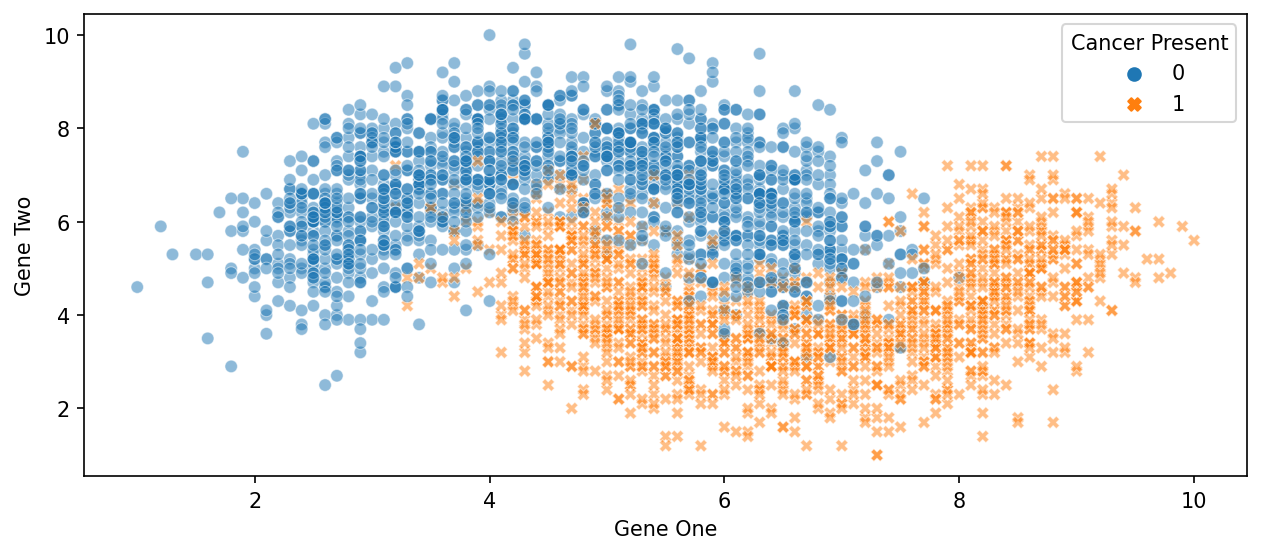

In [8]:
plt.figure(figsize=(10,4),dpi=150)
sns.scatterplot(data=df, x="Gene One", y="Gene Two", hue="Cancer Present",alpha=.5, style="Cancer Present");

In [7]:
len(df)

3000

/Users/brandonkwamou/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


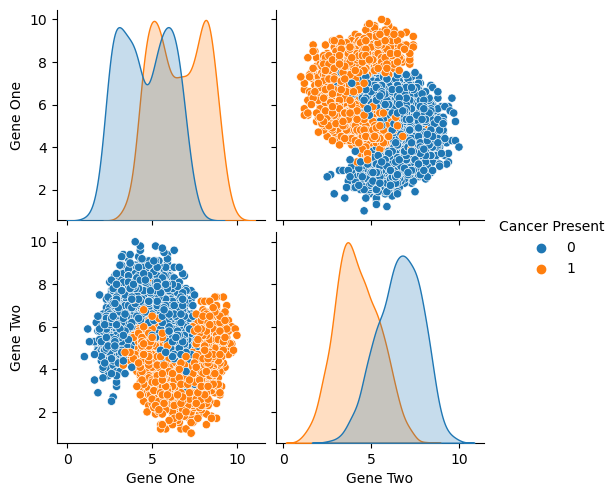

In [10]:
sns.pairplot(df, hue="Cancer Present")

**Split | Scale**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [15]:
scaler = StandardScaler()

In [16]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

**Model**

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
# help(KNeighborsClassifier)

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [21]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [22]:
y_pred = knn_model.predict(scaled_X_test)

**Evaluation**

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

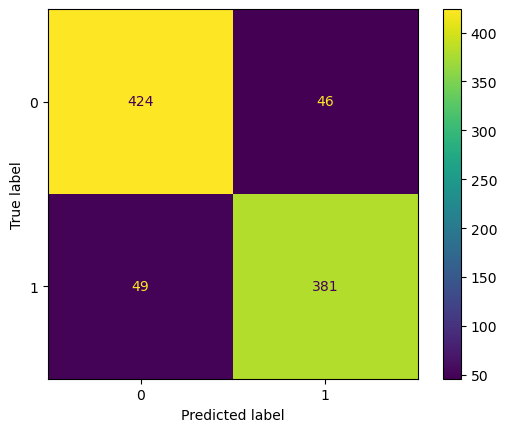

In [24]:
ConfusionMatrixDisplay.from_estimator(knn_model, scaled_X_test,y_test)

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       470
           1       0.89      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



In [26]:
df['Cancer Present'].value_counts()

Cancer Present
1    1500
0    1500
Name: count, dtype: int64

# Part Two: Choosing K

**Elbow Method**

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train)
    
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    
    test_error_rates.append(test_error)

In [30]:
# test_error_rates

Text(0.5, 0, 'K Neighbors')

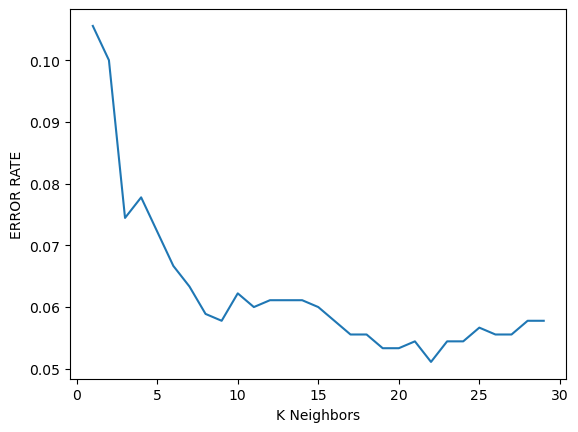

In [31]:
plt.plot(range(1,30),test_error_rates)
plt.ylabel('ERROR RATE')
plt.xlabel('K Neighbors');

**Cross validate a grid search**

In [32]:
# PIPELINE --> GRIDSEARCH CV

In [33]:
scaler = StandardScaler()

In [34]:
knn = KNeighborsClassifier()

In [35]:
# first you scale the data then you use the model
operations = [('scaler',scaler),('knn',knn)]

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
# series of steps executed in order
pipe = Pipeline(operations)

In [38]:
from sklearn.model_selection import GridSearchCV

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [39]:
k_values = list(range(1,30))

In [40]:
param_grid = {'knn__n_neighbors':k_values}

In [41]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [42]:
# Use full X and y if you DON'T want a hold-out test set
# Use X_train and y_train if you DO want a holdout test set (X_test,y_test)
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [44]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=20))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=20),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 20,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Let's check our understanding:
**How many total runs did we do?**

In [45]:
len(k_values)

29

In [46]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90333333, 0.90571429, 0.92095238, 0.91285714, 0.92428571,
       0.91857143, 0.9252381 , 0.9252381 , 0.9247619 , 0.92285714,
       0.9252381 , 0.92333333, 0.92809524, 0.92952381, 0.92857143,
       0.92857143, 0.92857143, 0.92857143, 0.92714286, 0.93047619,
       0.92857143, 0.93047619, 0.92761905, 0.92809524, 0.92714286,
       0.92714286, 0.92857143, 0.92857143, 0.92952381])

## Final Model

We just saw that our  GridSearch recommends a K=20 (in line with our alternative Elbow Method). Let's now use the PipeLine again, but this time, no need to do a grid search, instead we will evaluate on our hold-out Test Set.

In [47]:
scaler = StandardScaler()
knn20 = KNeighborsClassifier(n_neighbors=20)
operations = [('scaler',scaler),('knn20',knn20)]

In [48]:
pipe = Pipeline(operations)

In [49]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn20', KNeighborsClassifier(n_neighbors=20))])

In [51]:
pipe_pred = pipe.predict(X_test)

In [52]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [59]:
single_sample = X_test.iloc[40]

In [60]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [61]:
pipe.predict(single_sample.values.reshape(1, -1))

/Users/brandonkwamou/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0])

In [56]:
pipe.predict_proba(single_sample.values.reshape(1, -1))

/Users/brandonkwamou/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.85, 0.15]])